In [1]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_p in imgs:
        file_features = []
        image = cv2.imread(file_p) # Read in each imageone by one
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
        feature_image=cv2.flip(feature_image,1) # Augment the dataset with flipped images
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel)
        features.append(np.concatenate(file_features))
    return features # Return list of feature vectors

# Define a function to extract features from a list of images
def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #print 'spat', spatial_features.shape
        file_features.append(spatial_features)
    if hist_feat == True:
         # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #print 'hist', hist_features.shape
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = list()
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #print 'hog', hog_features.shape
            # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from collections import deque
history = deque(maxlen = 8)

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  #9 HOG orientations
pix_per_cell = 8 #8 HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

# Read in cars and notcars
images = glob.glob('*vehicles/*/*')
cars = []
notcars = []
for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)

print(len(cars))
print(len(notcars))

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('car samples: ', len(car_features))

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('notcar samples: ', len(notcar_features))

#X = np.vstack((car_features, notcar_features)).astype(np.float64)
X = car_features + notcar_features
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
#y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
y = np.concatenate([np.ones(len(car_features)), np.zeros(len(notcar_features))])
print(y.shape)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


8792
8968


C:\Users\khalid18\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


car samples:  17584
notcar samples:  17936
(35520,)
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
102.94 Seconds to train SVC...
Test Accuracy of SVC =  0.992


C:\Users\khalid18\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


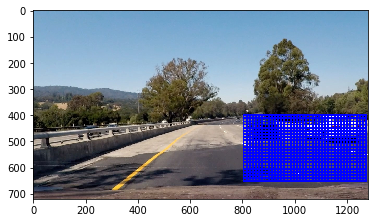

In [3]:

img = mpimg.imread('./test_images/test4.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    '''
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image) 
    '''
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            X = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(X)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
                        
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                if (xbox_left > 800):
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    window_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    return draw_img, window_list
    
scale = 1.50
    
out_img, window_list = find_cars(img, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)

plt.imshow(out_img)
plt.show()

In [ ]:
# ------------------------------------------------
# Advanced Lane finding algorithm begins here:
# ------------------------------------------------
from adv_lanes import *
from scipy.ndimage.measurements import label

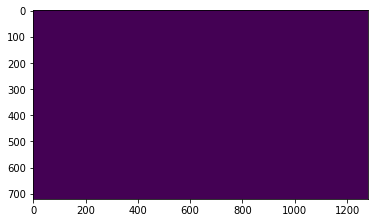

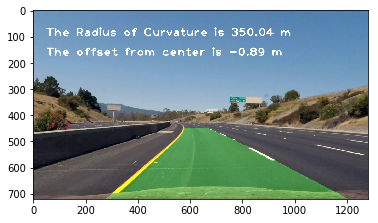

[MoviePy] >>>> Building video ./test_project_video_2.mp4
[MoviePy] Writing video ./test_project_video_2.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

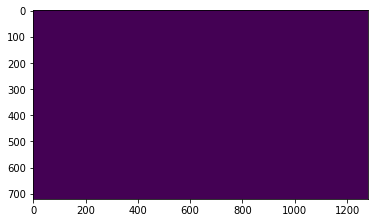

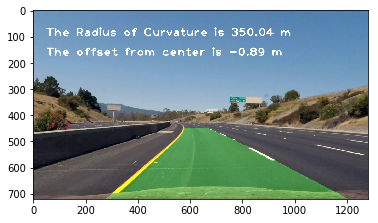

  0%|          | 1/1261 [00:23<8:17:42, 23.70s/it]

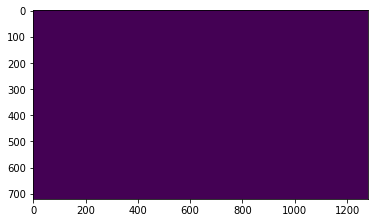

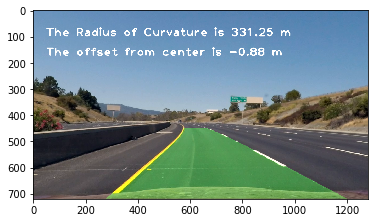

  0%|          | 2/1261 [00:47<8:19:19, 23.80s/it]

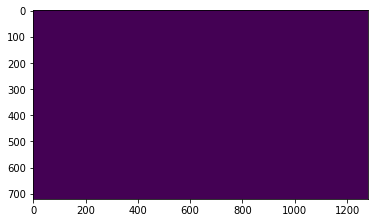

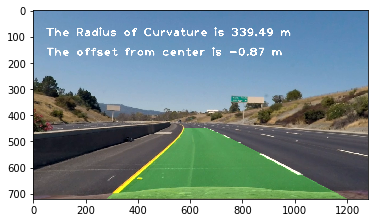

  0%|          | 3/1261 [01:10<8:11:45, 23.45s/it]

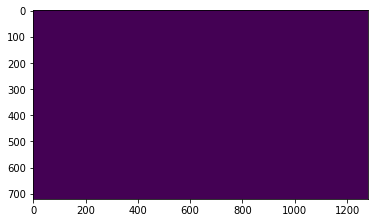

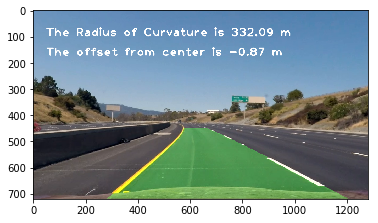

  0%|          | 4/1261 [01:33<8:08:46, 23.33s/it]

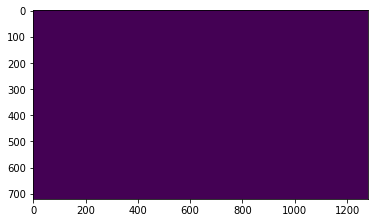

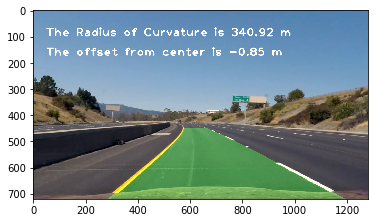

  0%|          | 5/1261 [01:57<8:11:18, 23.47s/it]

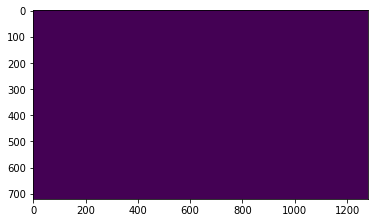

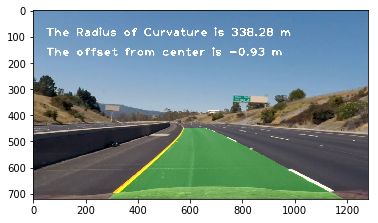

  0%|          | 6/1261 [02:21<8:15:38, 23.70s/it]

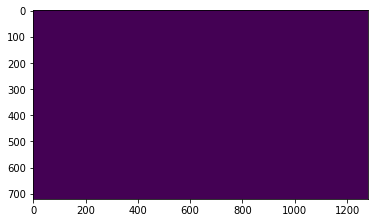

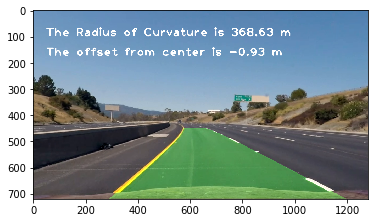

  1%|          | 7/1261 [02:47<8:27:53, 24.30s/it]

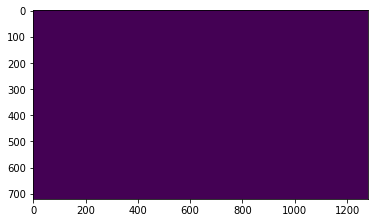

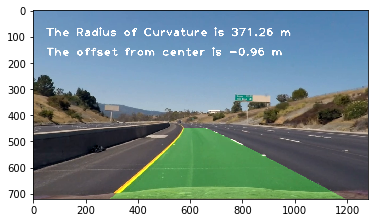

  1%|          | 8/1261 [03:12<8:33:43, 24.60s/it]

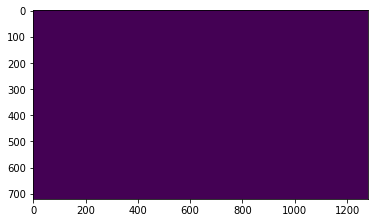

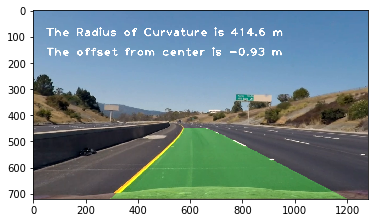

  1%|          | 9/1261 [03:37<8:36:12, 24.74s/it]

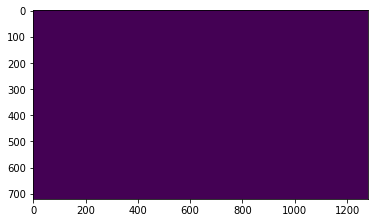

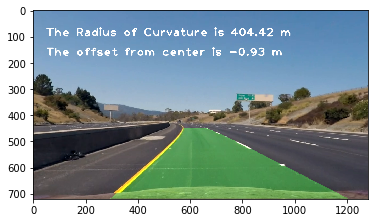

  1%|          | 10/1261 [04:02<8:35:58, 24.75s/it]

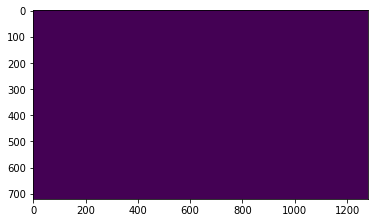

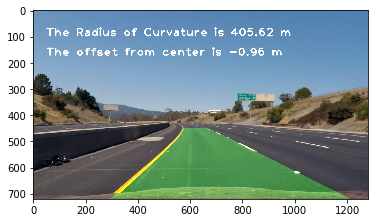

  1%|          | 11/1261 [04:26<8:32:52, 24.62s/it]

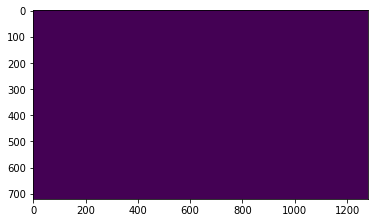

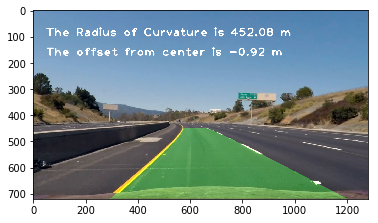

  1%|          | 12/1261 [04:50<8:27:25, 24.38s/it]

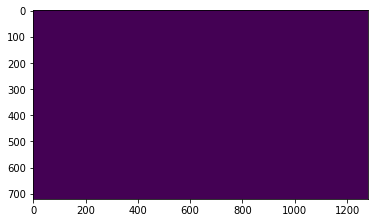

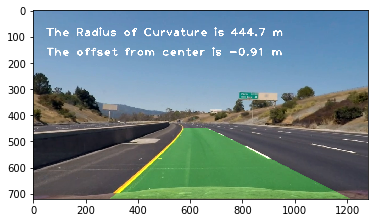

  1%|          | 13/1261 [05:16<8:36:21, 24.82s/it]

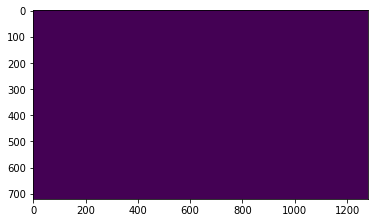

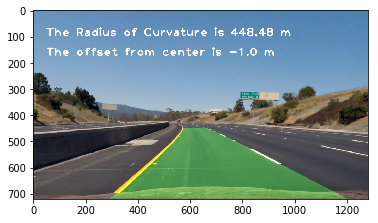

  1%|          | 14/1261 [05:39<8:24:10, 24.26s/it]

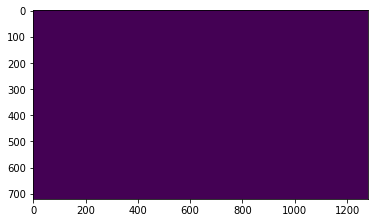

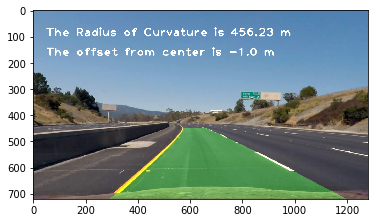

  1%|          | 15/1261 [06:01<8:12:15, 23.70s/it]

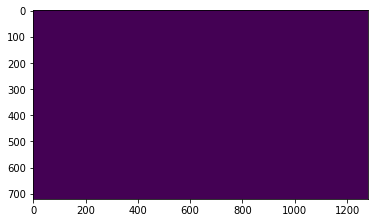

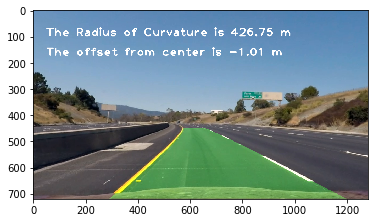

  1%|▏         | 16/1261 [06:26<8:21:06, 24.15s/it]

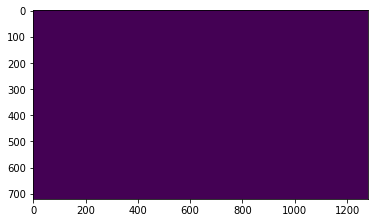

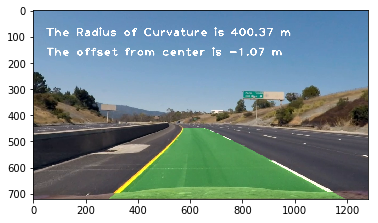

  1%|▏         | 17/1261 [06:55<8:46:27, 25.39s/it]

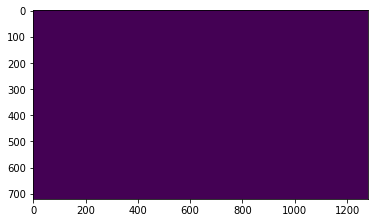

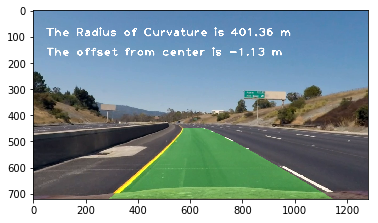

  1%|▏         | 18/1261 [07:23<9:03:24, 26.23s/it]

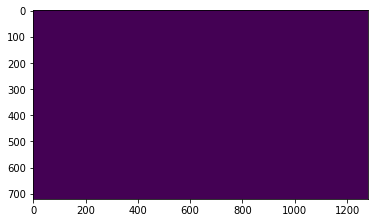

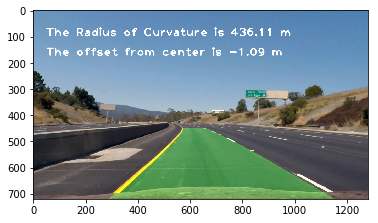

  2%|▏         | 19/1261 [07:53<9:29:09, 27.50s/it]

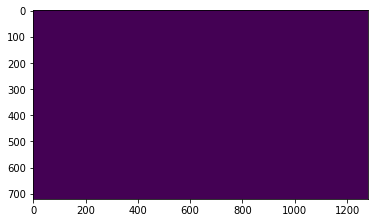

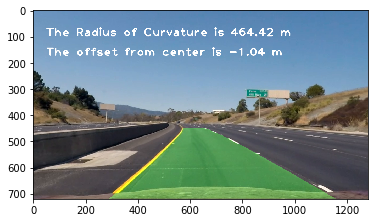

  2%|▏         | 20/1261 [08:21<9:31:52, 27.65s/it]

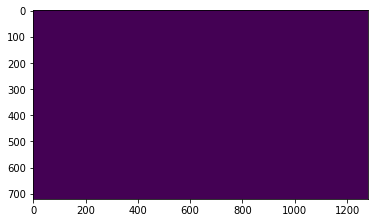

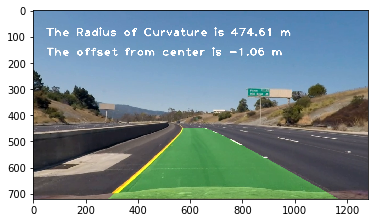

  2%|▏         | 21/1261 [08:50<9:37:11, 27.93s/it]

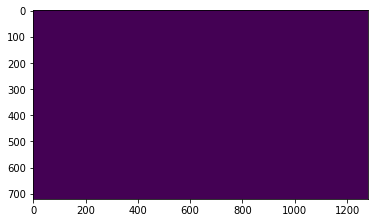

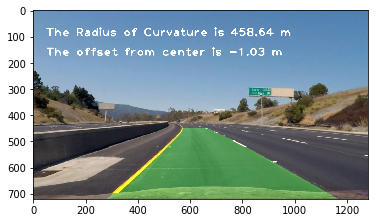

  2%|▏         | 22/1261 [09:18<9:35:39, 27.88s/it]

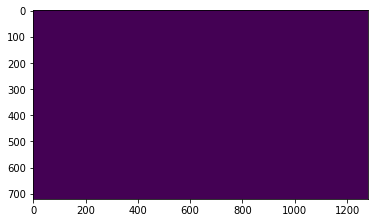

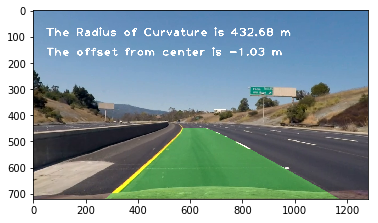

  2%|▏         | 23/1261 [09:44<9:29:04, 27.58s/it]

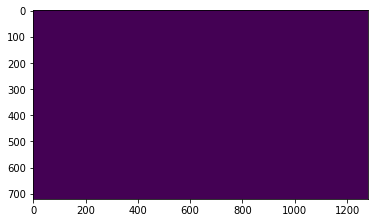

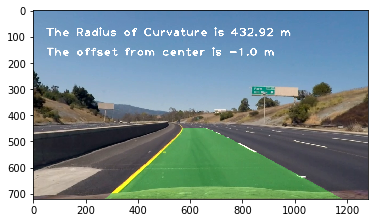

  2%|▏         | 24/1261 [10:11<9:21:23, 27.23s/it]

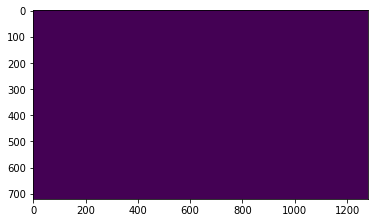

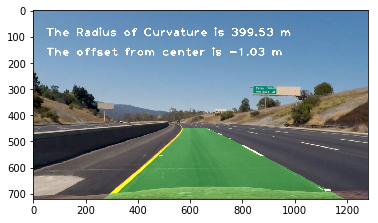

  2%|▏         | 25/1261 [10:37<9:13:09, 26.85s/it]

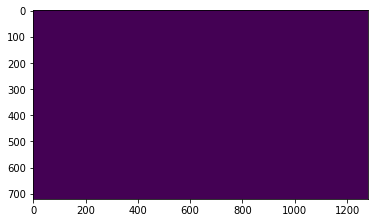

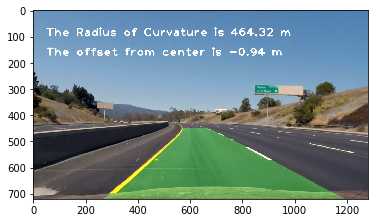

  2%|▏         | 26/1261 [11:02<9:00:10, 26.24s/it]

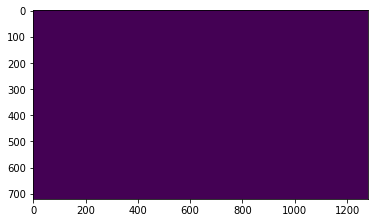

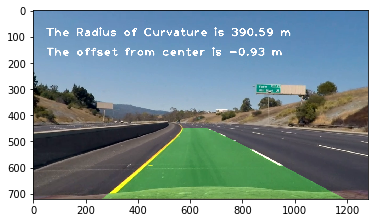

  2%|▏         | 27/1261 [11:26<8:48:41, 25.71s/it]

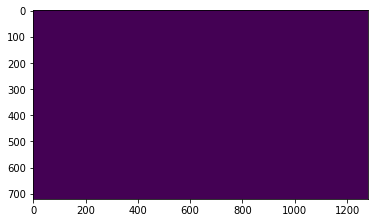

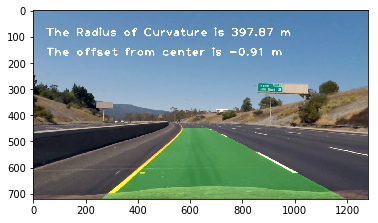

  2%|▏         | 28/1261 [11:51<8:40:25, 25.32s/it]

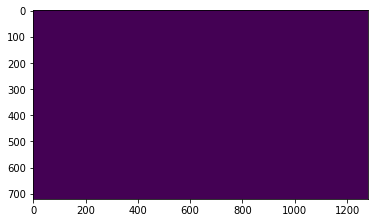

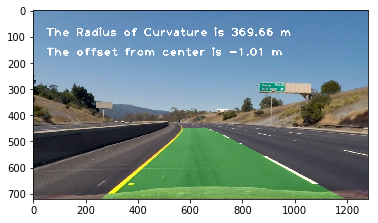

  2%|▏         | 29/1261 [12:15<8:36:46, 25.17s/it]

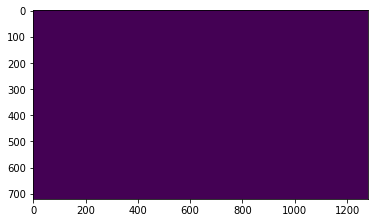

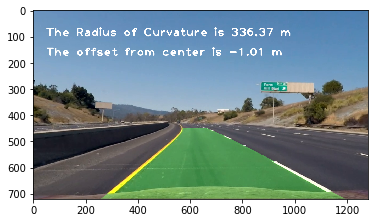

  2%|▏         | 30/1261 [12:41<8:36:47, 25.19s/it]

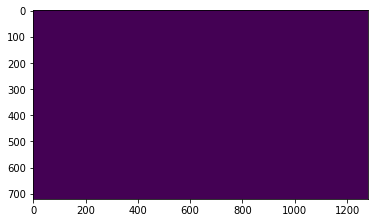

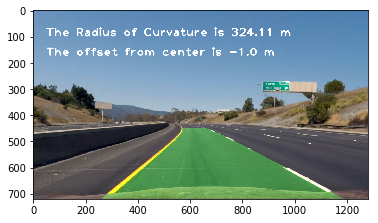

  2%|▏         | 31/1261 [13:06<8:35:39, 25.15s/it]

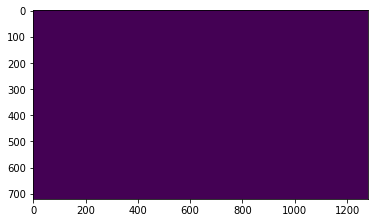

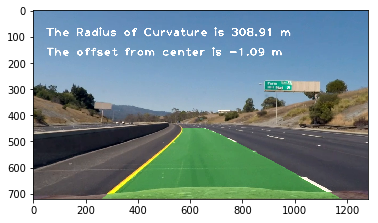

  3%|▎         | 32/1261 [13:31<8:39:01, 25.34s/it]

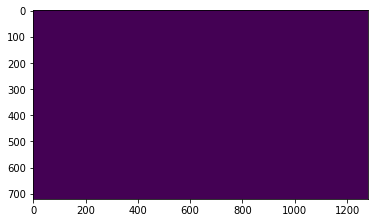

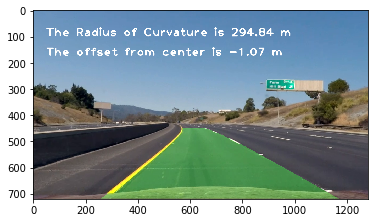

  3%|▎         | 33/1261 [13:57<8:41:48, 25.50s/it]

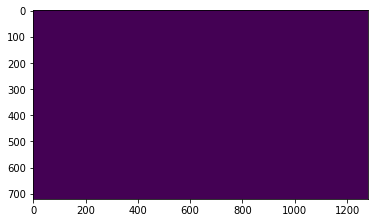

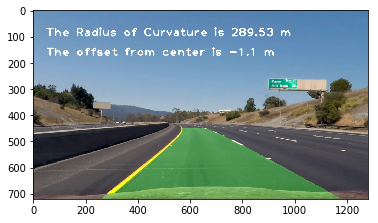

  3%|▎         | 34/1261 [14:24<8:46:10, 25.73s/it]

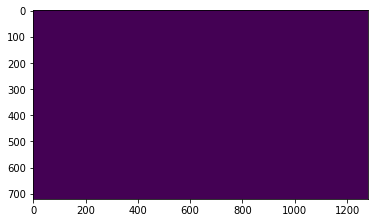

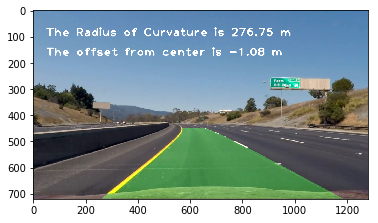

  3%|▎         | 35/1261 [14:49<8:46:26, 25.76s/it]

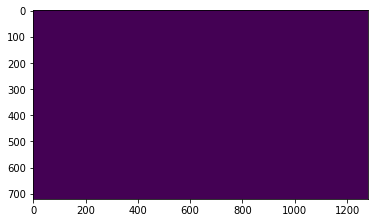

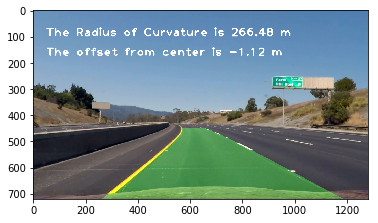

  3%|▎         | 36/1261 [15:15<8:45:33, 25.74s/it]

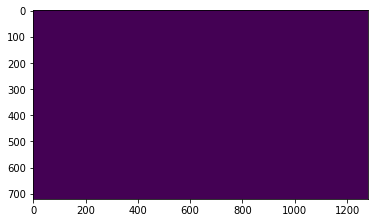

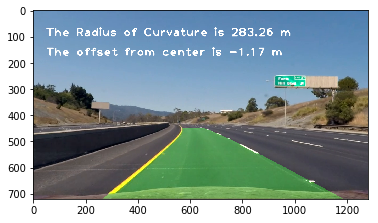

  3%|▎         | 37/1261 [15:41<8:47:08, 25.84s/it]

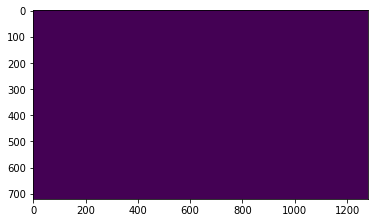

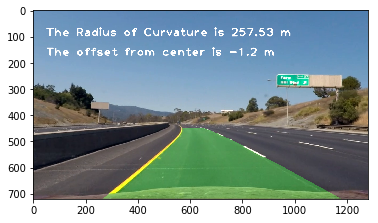

  3%|▎         | 38/1261 [16:07<8:45:56, 25.80s/it]

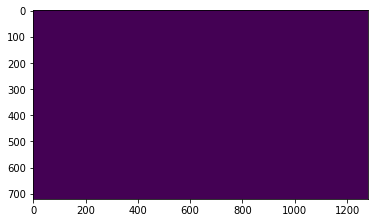

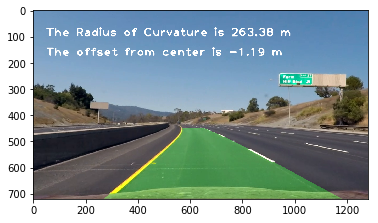

  3%|▎         | 39/1261 [16:33<8:48:52, 25.97s/it]

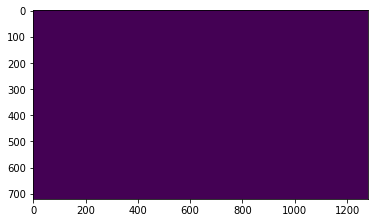

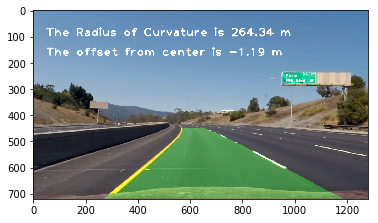

  3%|▎         | 40/1261 [17:00<8:50:13, 26.05s/it]

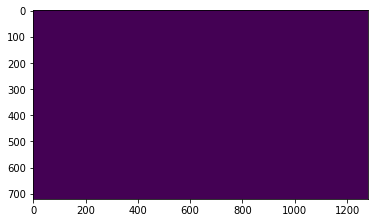

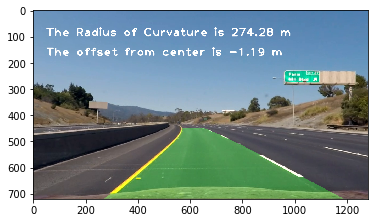

  3%|▎         | 41/1261 [17:26<8:51:14, 26.13s/it]

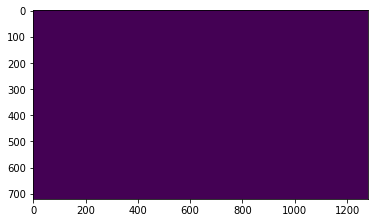

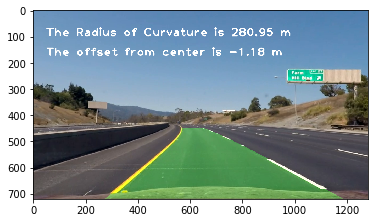

  3%|▎         | 42/1261 [17:52<8:48:57, 26.04s/it]

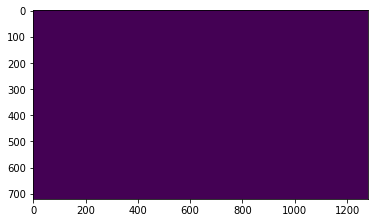

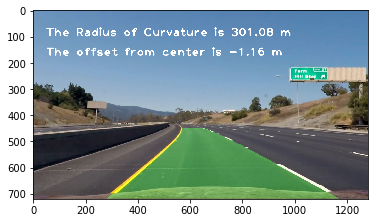

  3%|▎         | 43/1261 [18:18<8:52:02, 26.21s/it]

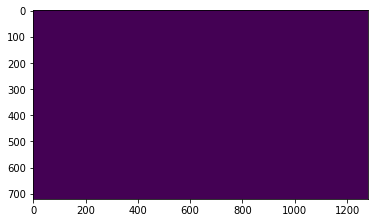

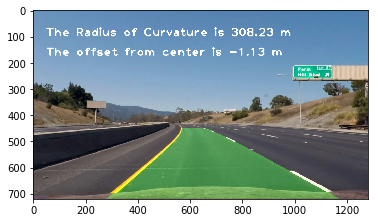

  3%|▎         | 44/1261 [18:43<8:44:29, 25.86s/it]

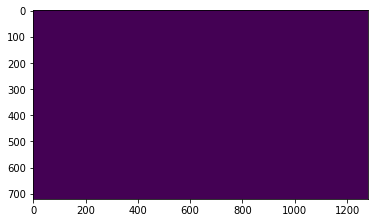

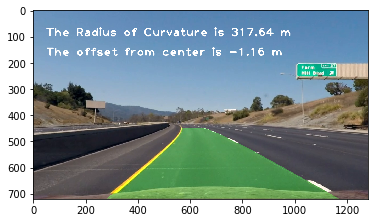

  4%|▎         | 45/1261 [19:09<8:43:18, 25.82s/it]

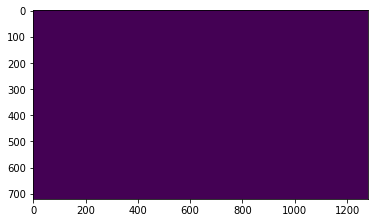

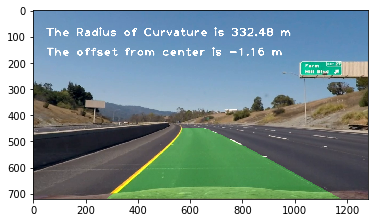

  4%|▎         | 46/1261 [19:34<8:39:19, 25.65s/it]

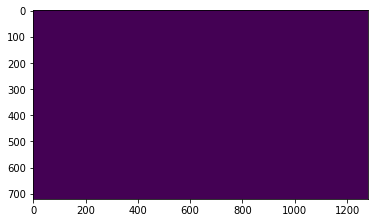

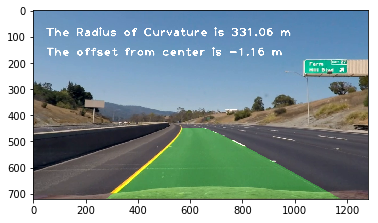

  4%|▎         | 47/1261 [19:59<8:33:20, 25.37s/it]

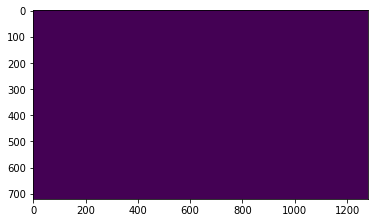

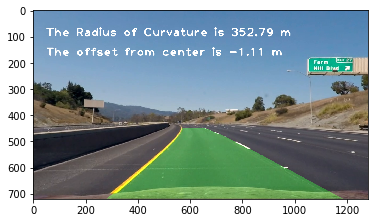

  4%|▍         | 48/1261 [20:22<8:15:49, 24.53s/it]

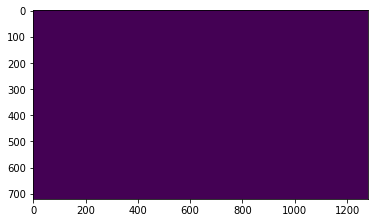

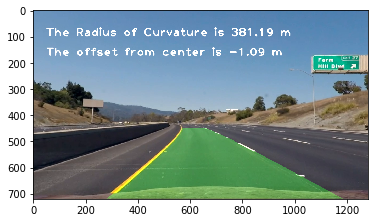

  4%|▍         | 49/1261 [20:44<8:05:04, 24.01s/it]

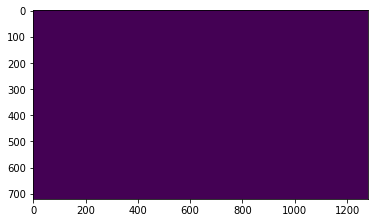

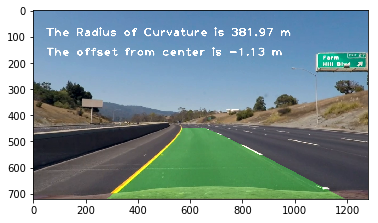

  4%|▍         | 50/1261 [21:08<8:01:25, 23.85s/it]

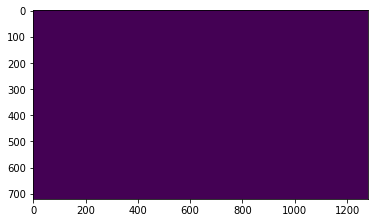

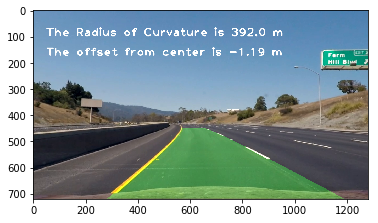

  4%|▍         | 51/1261 [21:33<8:10:30, 24.32s/it]

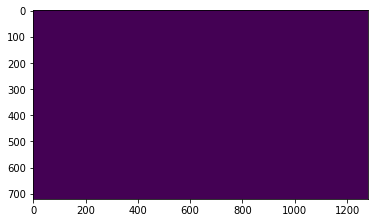

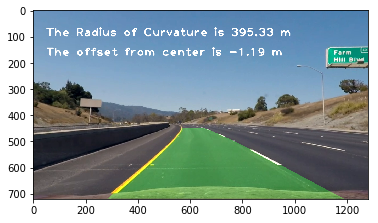

  4%|▍         | 52/1261 [21:55<7:57:14, 23.68s/it]

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def pipeline(image, y_start_stop, svc, X_scaler, color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat, scale):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Find the lane markings
    objpoints, imgpoints, gray = calibrate_camera()
    undistorted = undistort_and_display(image, objpoints, imgpoints, gray)
    stacky = clr_and_grad_threshold(image)
    binary_warped, Minv = perspective_tranform(stacky)
    left_fitx, right_fitx, nonzerox, nonzeroy, left_lfane_inds, right_lane_inds, leftx, lefty, rightx, righty, ploty = lane_capture(binary_warped)
    #ploty, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds = draw_lines(binary_warped, left_fit, right_fit)
    #out_img = display_img(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, rightx, ploty)
    #plot_windows(binary_warped, left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    #draw_lanes() # Using synthetic data for demo purposes
    roc = calculate_roc(ploty, left_fitx, right_fitx)
    pre_result = draw_shaded_region(stacky, left_fitx, right_fitx, ploty, Minv, undistorted)
    
    windows = []
    '''
    ystart = 400
    ystop = 464
    scale = 1.0
    out_img1, windows1 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    ystart = 416
    ystop = 480
    scale = 1.0
    out_img1, windows2 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    ystart = 400
    ystop = 496
    scale = 1.5
    out_img1, windows3 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    ystart = 432
    ystop = 528
    scale = 1.5
    out_img1, windows4 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    ystart = 400
    ystop = 528
    scale = 2.0
    out_img1, windows5 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    ystart = 432
    ystop = 560
    scale = 2.0
    out_img1, windows6 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    ystart = 400
    ystop = 596
    scale = 3.5
    out_img1, windows7 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    ystart = 464
    ystop = 660
    scale = 3.5
    out_img1, windows8 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    
    '''
    out_img1, windows1 = find_cars(image, y_start_stop[0], y_start_stop[1], 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    out_img2, windows2 = find_cars(image, y_start_stop[0], y_start_stop[1], 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    out_img3, windows3 = find_cars(image, y_start_stop[0], y_start_stop[1], 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    out_img4, windows4 = find_cars(image, y_start_stop[0], y_start_stop[1], 2.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    
    
    windows = windows1+windows2+windows3+windows4
    #windows = windows1+windows2+windows3+windows4+windows5+windows6+windows7+windows8
        
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    history.append(heatmap)
    
    heatmap_temp = np.zeros_like(heatmap).astype(np.float)
    for i in history:
        heatmap_temp = heatmap_temp + i 
        
    plt.imshow(heatmap_temp)
    plt.show()

    # Find final boxes from heatmap using label function
    labels = label(heatmap_temp)
    
    draw_img = draw_labeled_bboxes(np.copy(pre_result), labels)
       
    result = write_roc(draw_img, roc, np.min(leftx), np.min(rightx))
    
    plt.imshow(result)
    plt.show()
    
    return result

'''
for i in glob.glob('.//test_images//*.jpg'):
    history = deque(maxlen = 8)
    img_test = mpimg.imread(i)
    result = pipeline(img_test, y_start_stop, svc, X_scaler, color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat, scale)
    plt.imshow(result)
    plt.show()


history = deque(maxlen = 8)
img_test = mpimg.imread('.//test_images//test1.jpg')
result = pipeline(img_test, y_start_stop, svc, X_scaler, color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat, scale)
plt.imshow(result)
plt.show()
'''

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    result = pipeline(image, y_start_stop, svc, X_scaler, color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat, scale)
    return result

history = deque(maxlen = 8)
white_output = './test_project_video_2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))
